In [1]:
import load_data
import rotplot

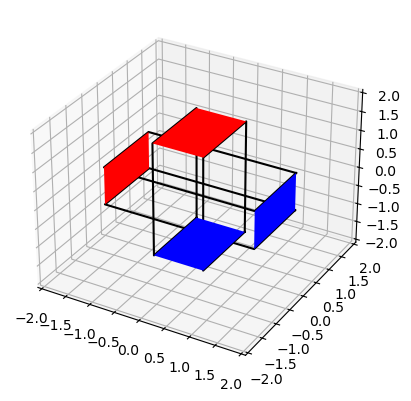

In [2]:
rotplot.example()